In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import numpy as np
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 20

from future_features import tape
from mapper import Mapper

from testsuite import *

from sklearn.cluster import KMeans

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __

In [2]:
N = 1000
Ntest = 1000

n_features = 2
n_components = 4
n_restarts = 4
n_datasets = 4
deviations = np.logspace(-3,1,5, dtype='float32')[-1:]

In [3]:
deviation = deviations[-1] # take a large-variance prior on the cluster means, i.e. spread-out clusters, i.e. high snr

In [4]:
mixture_component_covariances_cholesky_df = .1
mixture_component_covariances_cholesky_scale_tril = (1./(mixture_component_covariances_cholesky_df - n_features - 1.))*tf.eye(n_features)

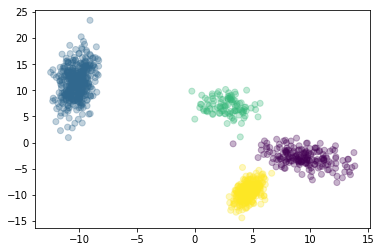

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5023.719727
  Number of iterations: 19
  Number of functions evaluations: 53
1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5023.720215
  Number of iterations: 15
  Number of functions evaluations: 33
3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5023.720215
  Number of iterations: 17
  Number of functions evaluations: 34
5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5023.720215
  Number of iterations: 18
  Number of functions evaluations: 35
7


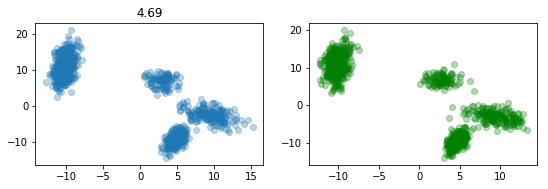

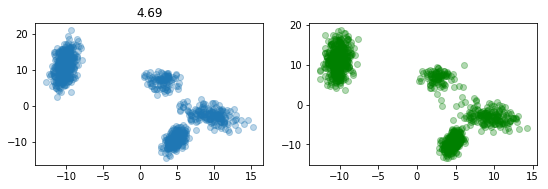

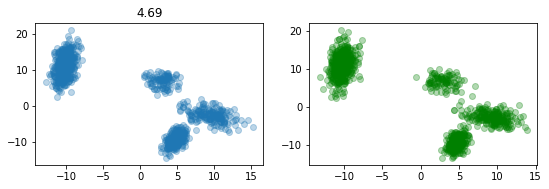

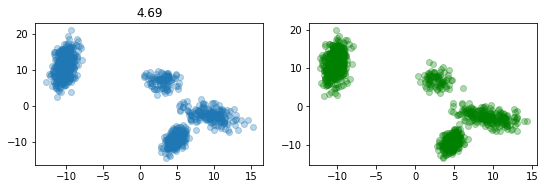

____________________________________________________________________________


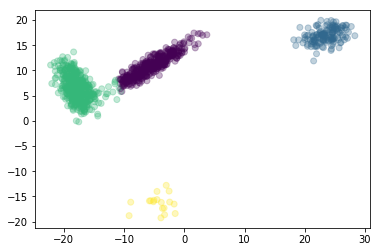

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5949.490723
  Number of iterations: 34
  Number of functions evaluations: 44
1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5949.491699
  Number of iterations: 34
  Number of functions evaluations: 53
3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5949.491211
  Number of iterations: 33
  Number of functions evaluations: 52
5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5949.492676
  Number of iterations: 33
  Number of functions evaluations: 47
7


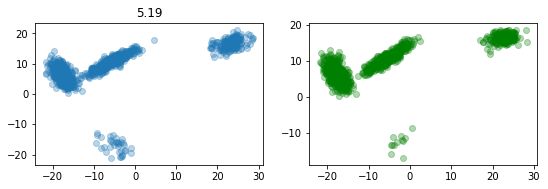

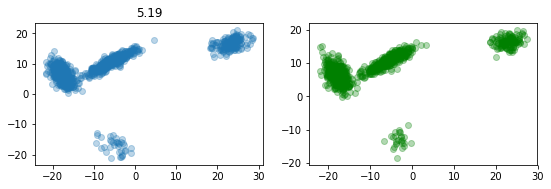

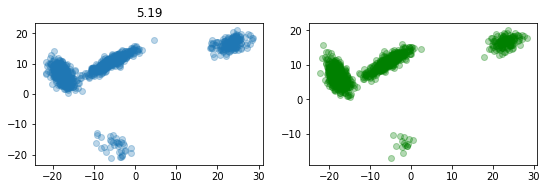

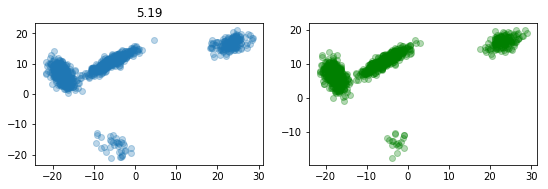

____________________________________________________________________________


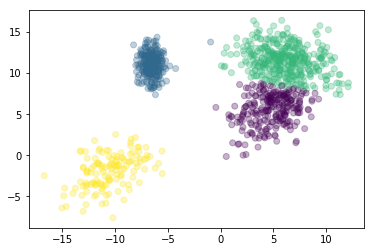

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5423.037109
  Number of iterations: 16
  Number of functions evaluations: 30
1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5423.036133
  Number of iterations: 20
  Number of functions evaluations: 41
3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5423.038086
  Number of iterations: 17
  Number of functions evaluations: 36
5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5423.036133
  Number of iterations: 21
  Number of functions evaluations: 32
7


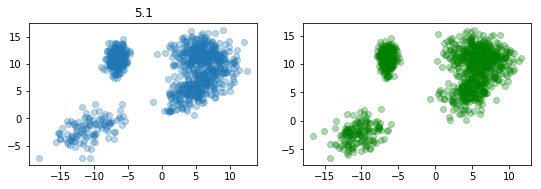

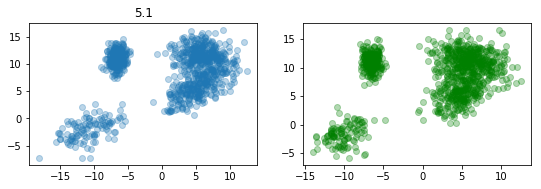

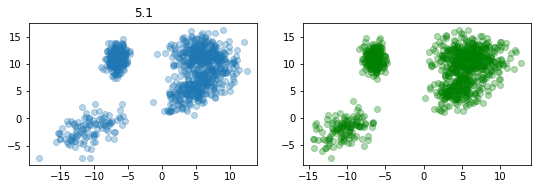

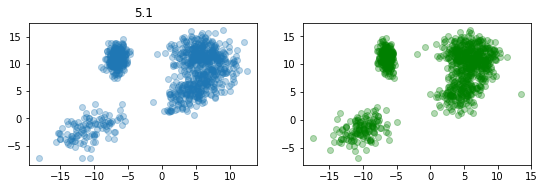

____________________________________________________________________________


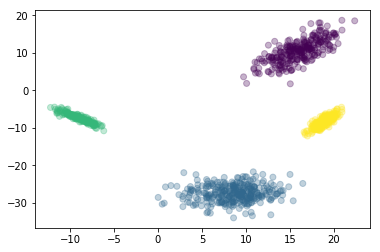

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5990.447754
  Number of iterations: 25
  Number of functions evaluations: 40
1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5990.447754
  Number of iterations: 23
  Number of functions evaluations: 37
3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5990.448242
  Number of iterations: 27
  Number of functions evaluations: 39
5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5990.447754
  Number of iterations: 25
  Number of functions evaluations: 38
7


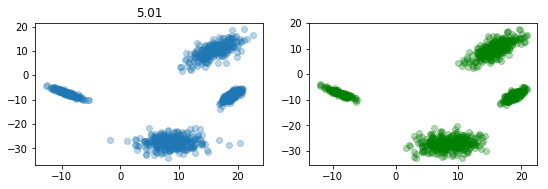

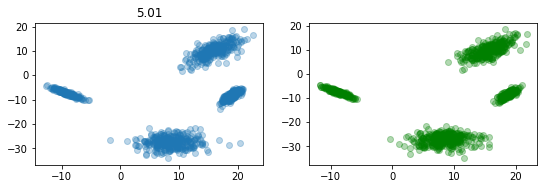

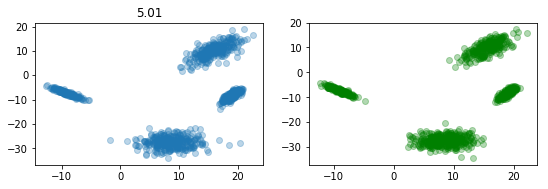

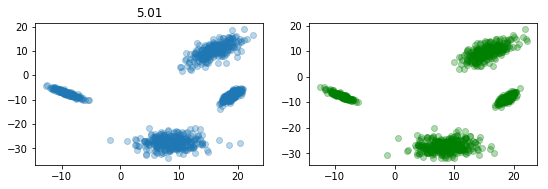

____________________________________________________________________________


In [5]:
models = []
models.append(Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=N, n_components=n_components, n_features=n_features, mixture_component_covariances_cholesky_scale_tril= mixture_component_covariances_cholesky_scale_tril))        
model_names = [model.model_name for model in models]
test_models = [mixtureOfGaussiansTest]

train_neg_log_lik_op = []
test_neg_log_lik_op = []
data_train = tf.placeholder(shape=(N,n_features), dtype='float32') 
data_test = tf.placeholder(shape=(Ntest,n_features), dtype='float32')
for model, test_model in zip(models, test_models):
    train_neg_log_lik_op.append(neg_log_lik(model.variables,test_model,data_train))
    test_neg_log_lik_op.append(neg_log_lik(model.variables,test_model,data_test))
    
train_neg_log_joint = xr.DataArray(np.zeros((len(models), len(deviations), n_restarts, n_datasets)),dims=['model', 'deviation', 'restart', 'dataset'], coords={'model': model_names, 'deviation': deviations, 'restart': range(n_restarts), 'dataset': range(n_datasets)})
train_neg_log_lik = xr.DataArray(np.zeros((len(models), len(deviations), n_restarts, n_datasets)),dims=['model', 'deviation', 'restart', 'dataset'], coords={'model': model_names, 'deviation': deviations, 'restart': range(n_restarts), 'dataset': range(n_datasets)})
test_neg_log_lik = xr.DataArray(np.zeros((len(models), len(deviations), n_restarts, n_datasets)),dims=['model', 'deviation', 'restart', 'dataset'], coords={'model': model_names, 'deviation': deviations, 'restart': range(n_restarts), 'dataset': range(n_datasets)})
placeholder_deviation = tf.placeholder(dtype='float32')

with tape() as reference_tf:
    data_tf = mixtureOfGaussians(n_observations=N + Ntest, n_components=4, n_features=n_features, mixture_component_means_std=placeholder_deviation)
with tf.Session() as sess:
    for dataset in range(n_datasets):
        data, reference = sess.run([data_tf, reference_tf], feed_dict={placeholder_deviation: deviation})

        # initialization by kmeans
        kmeans = KMeans(n_clusters=n_components).fit(data[:N])
        plt.scatter(*data[:N].T,c=kmeans.labels_,alpha=.3)
        plt.show()
        loss = {}
        opt = {}
        subplot_counter = 1
        for i,model in enumerate(models): 
            for restart in range(n_restarts):
                assign_default_ops = []
                sess.run(tf.global_variables_initializer())
                assign_default_ops.append(model.assigner(mixture_component_means=kmeans.cluster_centers_))
                #assign_default_ops.append(model.assigner(mixture_component_covariances_cholesky=reference['mixture_component_covariances_cholesky']))
                sess.run(assign_default_ops)
                loss[model.model_name], opt[model.model_name] = model.map_optimizer(data=data[:N])
                opt[model.model_name].minimize()
                MAP_parameter, converged_loss = sess.run([model.variables, loss[model.model_name]])
                train_neg_log_joint.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}] = converged_loss
                train_neg_log_lik.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}] = sess.run(train_neg_log_lik_op[i], feed_dict={data_train: data[:N]}) #neg_log_lik(model.variables,test_models[i],sess,data[:N])
                test_neg_log_lik.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}] = sess.run(test_neg_log_lik_op[i], feed_dict={data_test: data[N:]})#neg_log_lik(model.variables,test_models[i],sess,data[N:])
                mapmog = MAP_model(MAP_parameter,mixtureOfGaussiansTest,Ntest)
                plt.figure(figsize=(9, 12))
                print(subplot_counter)
                plt.subplot(n_restarts,2,subplot_counter)
                plt.title(str(np.round(test_neg_log_lik.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}].values,2)))
                plt.scatter(*data[Ntest:].T,alpha=.3)
                plt.subplot(n_restarts,2,subplot_counter+1)
                plt.scatter(*mapmog.distribution.sample(Ntest).eval().T,alpha=.3,c='g')
                subplot_counter += 2
        plt.show()
        print('____________________________________________________________________________')

In [6]:
reference

OrderedDict([('mixture_weights',
              array([0.2535684 , 0.25989562, 0.3107519 , 0.17578408], dtype=float32)),
             ('mixture_component_means', array([[ 18.908594,  -8.31805 ],
                     [ 15.654225,  10.227467],
                     [  8.496672, -27.56469 ],
                     [ -9.146053,  -7.295379]], dtype=float32)),
             ('mixture_component_covariances_cholesky',
              array([[[ 0.8311766 ,  0.        ],
                      [ 1.1388062 ,  0.89545566]],
              
                     [[ 2.3227005 ,  0.        ],
                      [ 2.249683  ,  2.2126873 ]],
              
                     [[ 2.9121037 ,  0.        ],
                      [ 0.21177383,  2.247631  ]],
              
                     [[ 1.3705186 ,  0.        ],
                      [-1.1555007 ,  0.45208502]]], dtype=float32)),
             ('data', array([[ -7.403284 ,  -8.385779 ],
                     [  9.719309 , -27.701834 ],
                  

In [7]:
MAP_parameter

{'mixture_weights': array([0.26596886, 0.3190092 , 0.16903262, 0.24598931], dtype=float32),
 'mixture_component_means': array([[ 15.580322,   9.931266],
        [  8.427695, -27.15156 ],
        [ -8.956668,  -7.424266],
        [ 18.819174,  -8.37944 ]], dtype=float32),
 'mixture_component_covariances_cholesky': array([[[ 2.090893  ,  0.        ],
         [ 1.8621249 ,  2.027124  ]],
 
        [[ 2.6356587 ,  0.        ],
         [ 0.1553265 ,  2.09451   ]],
 
        [[ 1.209283  ,  0.        ],
         [-1.0688674 ,  0.45969617]],
 
        [[ 0.79201895,  0.        ],
         [ 1.0625076 ,  0.80039656]]], dtype=float32)}